In [9]:
n_try = 1

model_names = [
               'CNN'
]

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from os.path import isdir
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [4]:
class DataProperties:
    main_dir = '/content/drive/MyDrive/ML/Datasets/4.Food5k/'
    validation_dir = main_dir + 'validation/'
    train_dir = main_dir + 'train/'
    test_dir = main_dir + 'test/'

    hackathon_dir = f'/content/drive/MyDrive/ML/Unox/{n_try}/'
    model_save_dir = hackathon_dir + 'Models/'
    histories_dir = hackathon_dir + 'Histories/'

# Prepare Data

In [12]:
target_shapes = {
    'CNN': (256, 256)
}

In [14]:
def preprocess(image):
    image = image / 255.
    return image

def prepare_validation_data(target_shape):

    val_use = 1  # 0.4

    val_generator = ImageDataGenerator(
        validation_split = 1 - val_use,

        preprocessing_function = preprocess,
        # samplewise_center = 
        # featurewise_center = 

        # width_shift_range = width_shift_range,
        # height_shift_range = height_shift_range,
        # rotation_range = rotation_range,
        # horizontal_flip = True,
        # vertical_flip = True,

        # brightness_range = 
        # zoom_range = zoom_range
    )

    val_flow = val_generator.flow_from_directory(
        directory = DataProperties.validation_dir,

        target_size = target_shape,
        color_mode = 'rgb',
        # classes = 
        class_mode = 'sparse',
        # batch_size = None,
        subset = 'training',
        shuffle = False,
        seed = 123
    )

    print(f'Use {val_flow.n} images for validation flow')

    return val_flow

val_flow = prepare_validation_data(
    target_shape = target_shapes['CNN']
)

Found 475 images belonging to 2 classes.
Use 475 images for validation flow


# Load models

In [23]:
def load_all_models(names_list):

    loaded_models = {
        name: load_model(f'{DataProperties.model_save_dir}{name}/') for name in names_list
    }

    return loaded_models

loaded_models = load_all_models(
    model_names
)

In [24]:
loaded_models['CNN'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 96)          331872    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 864)               0         
                                                                 
 dense (Dense)               (None, 10)                8

In [25]:
loaded_models['CNN'].evaluate(
    val_flow
)

15/15 [==============================] - 7s 488ms/step - loss: 0.5096 - accuracy: 0.7768


[0.5095794200897217, 0.7768421173095703]

# Load histories

In [27]:
from os.path import isfile
import pandas as pd

def load_histories(model_names):
    res = {n: None for n in model_names}

    for name in model_names:
        history_dir = f'{DataProperties.histories_dir}'
        assert(isdir(history_dir))

        file_path = f'{history_dir}{name}_history.csv'
        assert isfile(file_path)

        res[name] = pd.read_csv(file_path)
    return res


loaded_histories = load_histories(
    model_names
)

# Plot learning curves

In [32]:
def plot_metrics_history(history_df, metrics_name):
    fig, ax = plt.subplots()

    plot_d = dict(
        marker = 'o',
        markerfacecolor = 'white'
    )

    axis_d = dict(
        fontsize = 20
    )

    ax.plot(history_df[f'{metrics_name}'], **plot_d)
    ax.plot(history_df[f'val_{metrics_name}'], **plot_d)


    ax.set_xlabel('Epoch', **axis_d)
    ax.set_ylabel(f'Metrics: {metrics_name}', **axis_d)
    ax.set_title('Metrics VS epoch', **axis_d)

    ax.grid()
    legend_size = 15
    ax.legend(['train', 'validation'], prop = {'size': legend_size})

In [33]:
loaded_histories['CNN'].head()

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.640848,0.631476,0.555191,0.761161
1,1,0.563067,0.726295,0.525827,0.752232
2,2,0.513596,0.771261,0.491936,0.776786


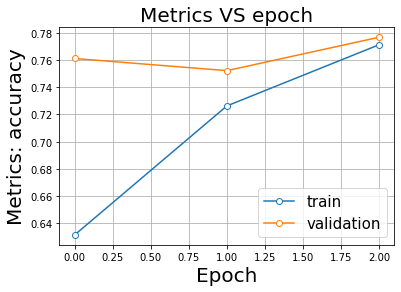

In [34]:
plot_metrics_history(
    loaded_histories['CNN'],
    metrics_name = 'accuracy'
)

# Compare number of trainable parameters

In [35]:
def calc_parameters(model):
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    return int(trainableParams + nonTrainableParams)

calc_parameters(
    loaded_models['CNN']
)

375477